This code creates a group average of the RDM maps from `RSA04_searchlight.py`


In [1]:
import numpy as np
import pandas as pd
import os, glob, re
from os.path import join
from pathlib import Path
import nilearn
import argparse
from nilearn import image, plotting
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm import threshold_stats_img
import matplotlib.pyplot as plt
from scipy.stats import norm
from nilearn.glm import cluster_level_inference
from nilearn import plotting
from nilearn.glm.second_level import SecondLevelModel
import nibabel as nib


### functions for averaging maps and plotting average maps

In [7]:
main_dir = '/Volumes/spacetop_projects_cue/'
nifti_dir = join(main_dir, 'analysis', 'fmri', 'nilearn', 'rsa', 'deriv03_searchlight')
def average_subwise_nifti(nifti_dir, model):

    # load images
    beta01_template = f'searchlight_*_*_model-{model}.nii.gz'
    second_level_input  = sorted(glob.glob(join(nifti_dir, '**', beta01_template), recursive = True))

    # load each image and append per subject key
    subject_maps = {}
    for file_path in second_level_input:

        file_name = os.path.basename(file_path)
        match = re.search(r'sub-(\d+)_ses-(\d+)', file_name)

        if match:
            subject = match.group(1)
            session = match.group(2)
        img = nib.load(file_path)
        data = img.get_fdata()
    
        if subject in subject_maps:
            subject_maps[subject].append(data)
        else:
            subject_maps[subject] = [data]

    # average subjectwise arrays within each key
    average_arrs = {}
    for subject, maps in subject_maps.items():
        average_arr = np.mean(maps, axis=0)
        average_arrs[subject] = average_arr

    # save as a new nifti file
    ref_img = image.load_img(second_level_input[20])

    for subject, average_arr in average_arrs.items():
        sub = 'sub-' + subject
        output_filename = join(nifti_dir, sub, f"searchlight_{sub}_ses-mean_model-{model}.nii.gz")
        average_img = image.new_img_like( ref_img, average_arr)
        nib.save(average_img, output_filename)
        # print(f"Saved: {output_filename}")
    print(f"finished saving {model} average maps")


In [8]:
def plot_average_nifti(nifti_dir, model):
    beta01_template = f'searchlight_*_ses-mean_model-{model}.nii.gz'
    second_level_input  = sorted(glob.glob(join(nifti_dir, '**', beta01_template), recursive = True))

    print(f"total number of images: {len(second_level_input)}")
    # print(f"filenames: {second_level_input}")

    design_matrix = pd.DataFrame(
        [1] * len(second_level_input), columns=["intercept"]
    )

    second_level_model = SecondLevelModel(smoothing_fwhm=6.0)
    second_level_model = second_level_model.fit(
        second_level_input, design_matrix=design_matrix
    )

    z_map = second_level_model.compute_contrast(output_type="z_score")


    p_val = 0.001
    p001_uncorrected = norm.isf(p_val)

    proportion_true_discoveries_img = cluster_level_inference(
        z_map, threshold=[3, 4, 5], alpha=0.05
    )

    display = plotting.plot_stat_map(
        proportion_true_discoveries_img,
        threshold=0.0,
        display_mode="mosaic",
        vmax=1,
        colorbar=True,
        title=f"{model}, proportion true positives",
    )
    display.title_fontsize = 24
    display = plotting.plot_stat_map(
        z_map,
        threshold=p001_uncorrected,
        colorbar=True,
        display_mode="mosaic",
        title=f"{model}, (uncorrected p < 0.001)",
    )
    display.title_fontsize = 24
    plotting.show()

## parameters

In [4]:
# parameters
main_dir ='/Volumes/spacetop_projects_cue/'
con_dir = join(main_dir, 'analysis', 'fmri', 'nilearn', 'rsa', 'deriv03_searchlight')


In [5]:
# load images
# TODO: average per participant and then stack
beta01_template = f'searchlight_*_*_model-cue.nii.gz'
second_level_input  = sorted(glob.glob(join(con_dir, '**', beta01_template), recursive = True))


In [9]:
for model in ['cue', 'stim', 'diagonal', 'grid', 'orthogonal', 'parallel', 'rotationgrid']:
    average_subwise_nifti(nifti_dir, model)

finished saving cue average maps
finished saving stim average maps
finished saving diagonal average maps
finished saving grid average maps
finished saving orthogonal average maps
finished saving parallel average maps
finished saving rotationgrid average maps


total number of images: 108


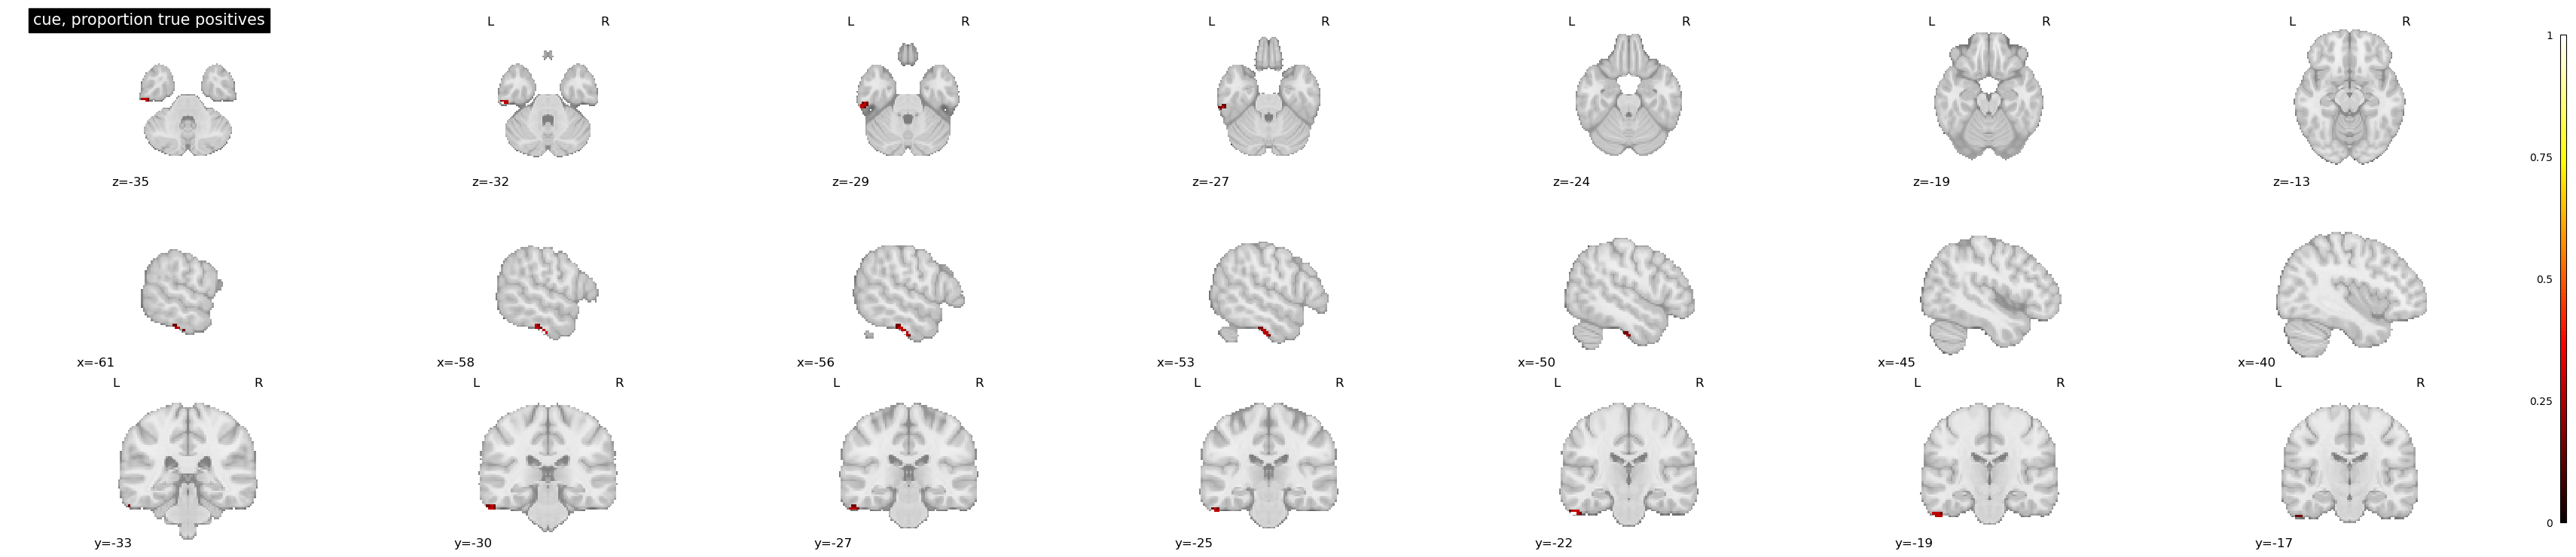

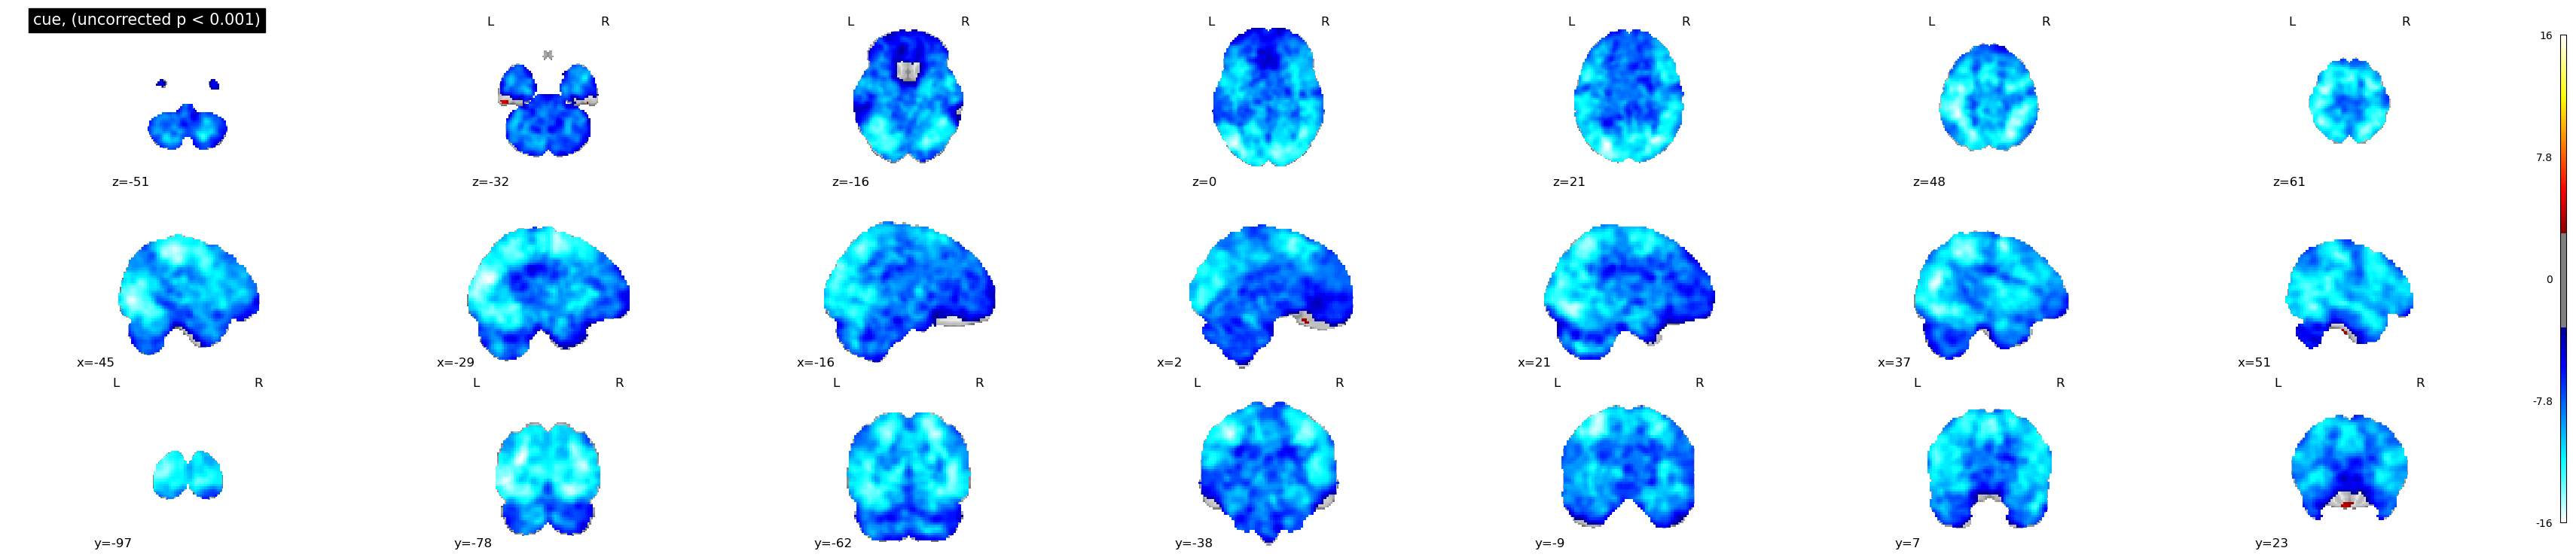

In [10]:
plot_average_nifti(nifti_dir, 'cue')

total number of images: 108


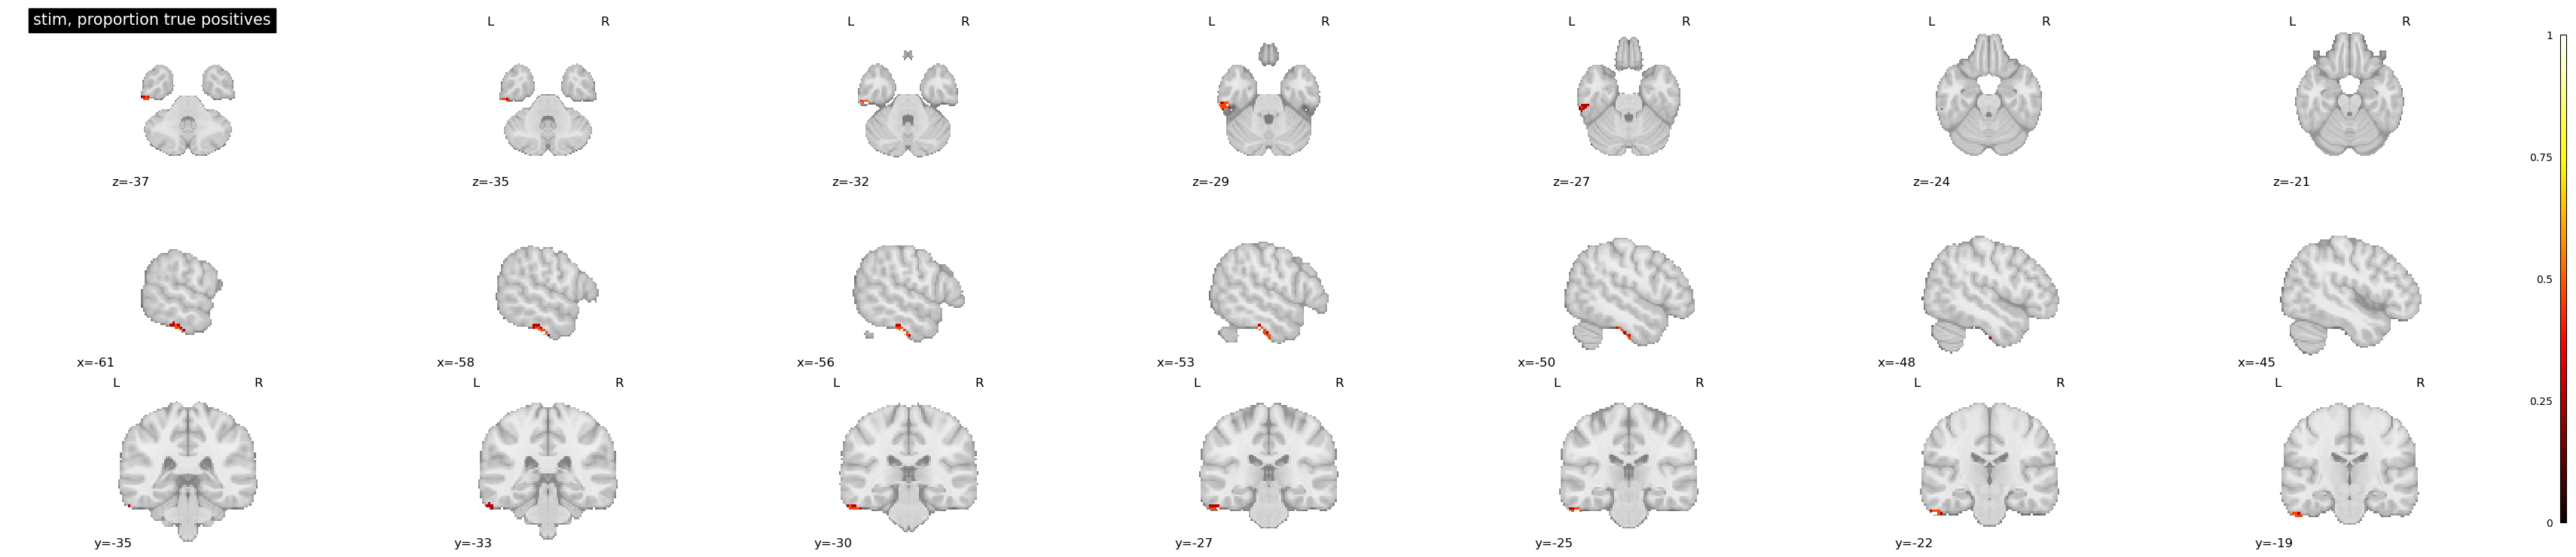

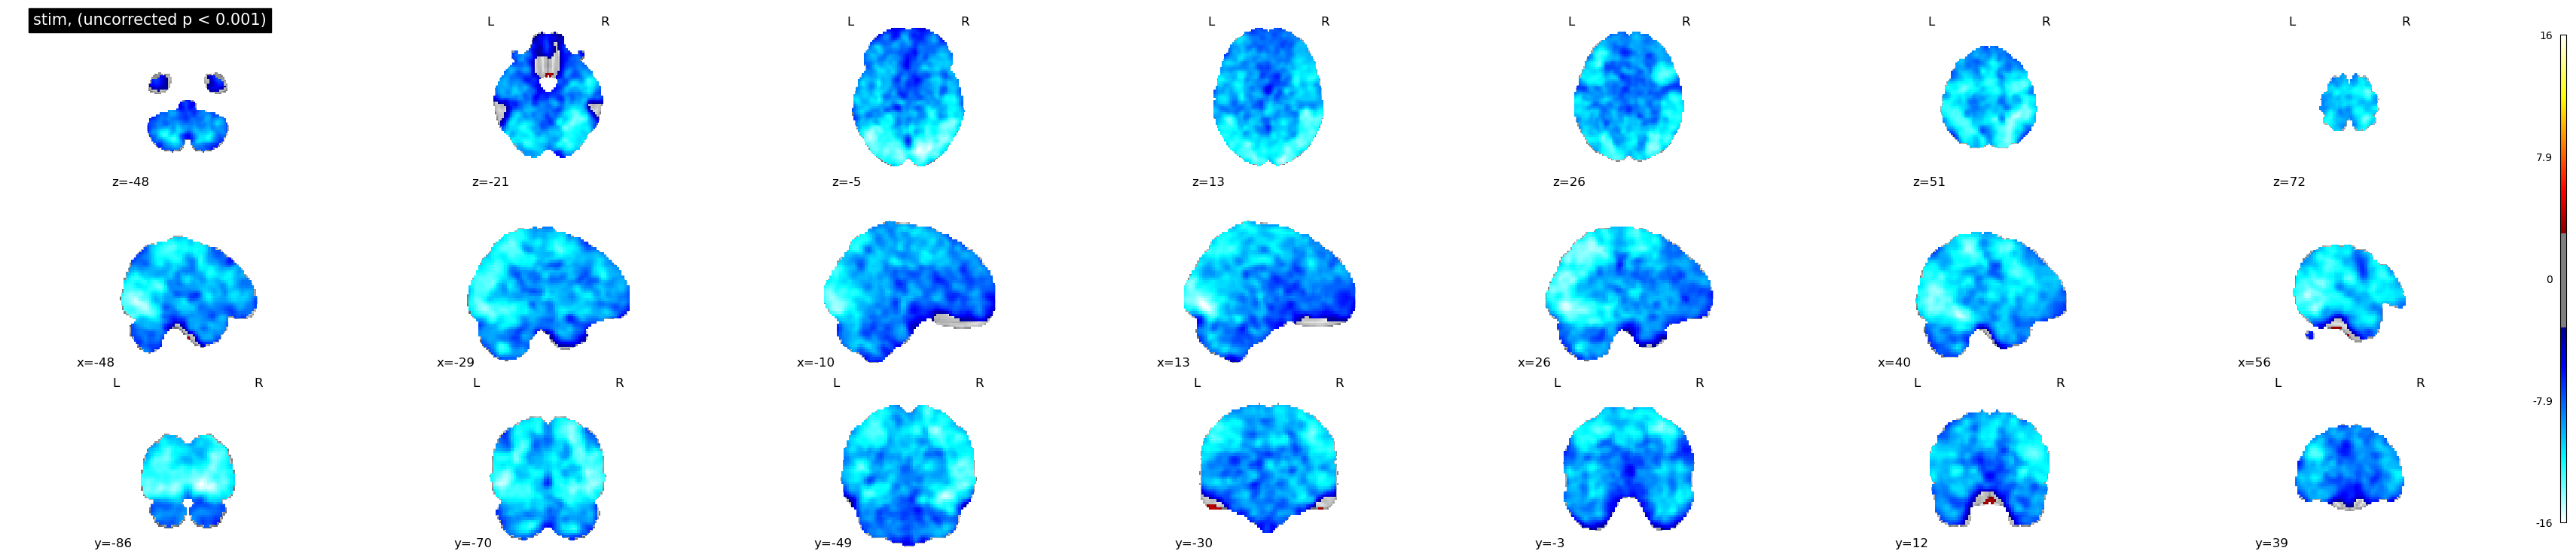

In [11]:
plot_average_nifti(nifti_dir, 'stim')

total number of images: 108


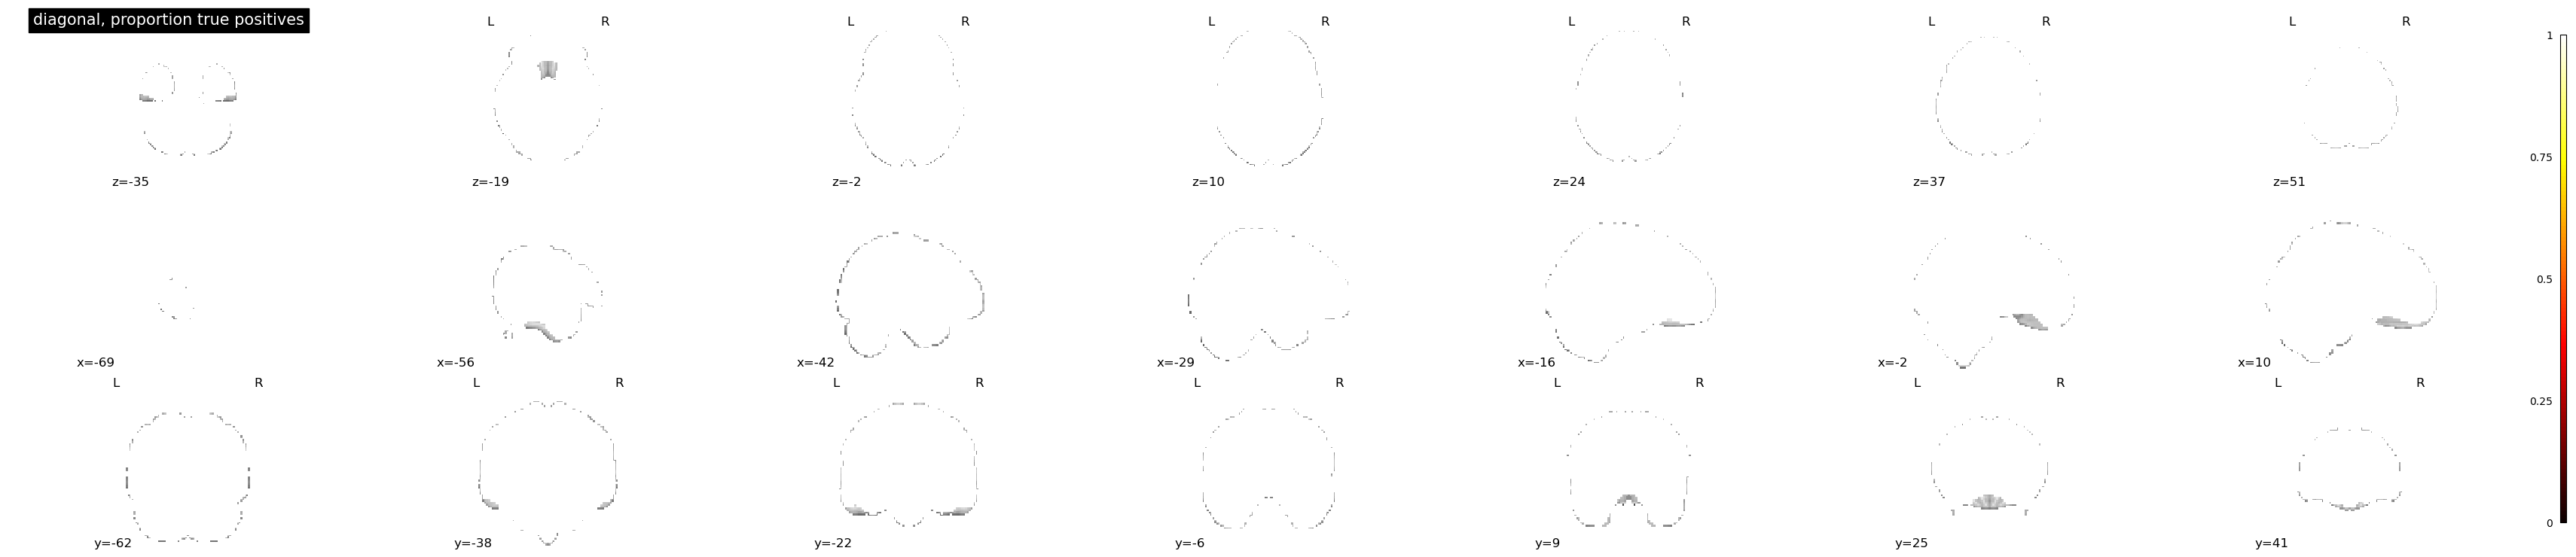

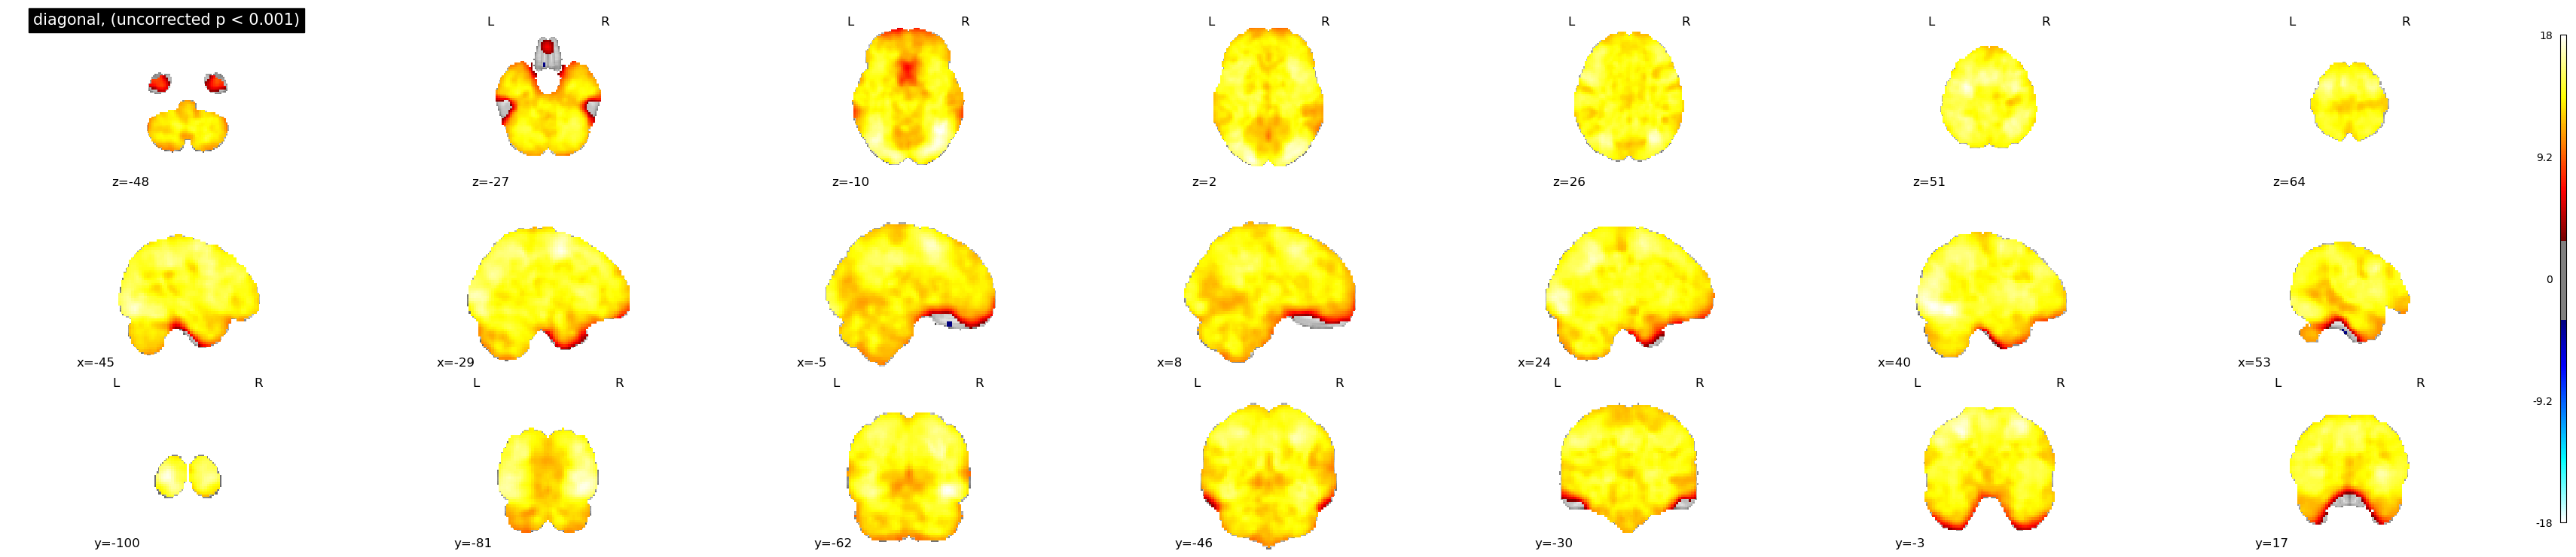

In [12]:
plot_average_nifti(nifti_dir, 'diagonal')

total number of images: 108


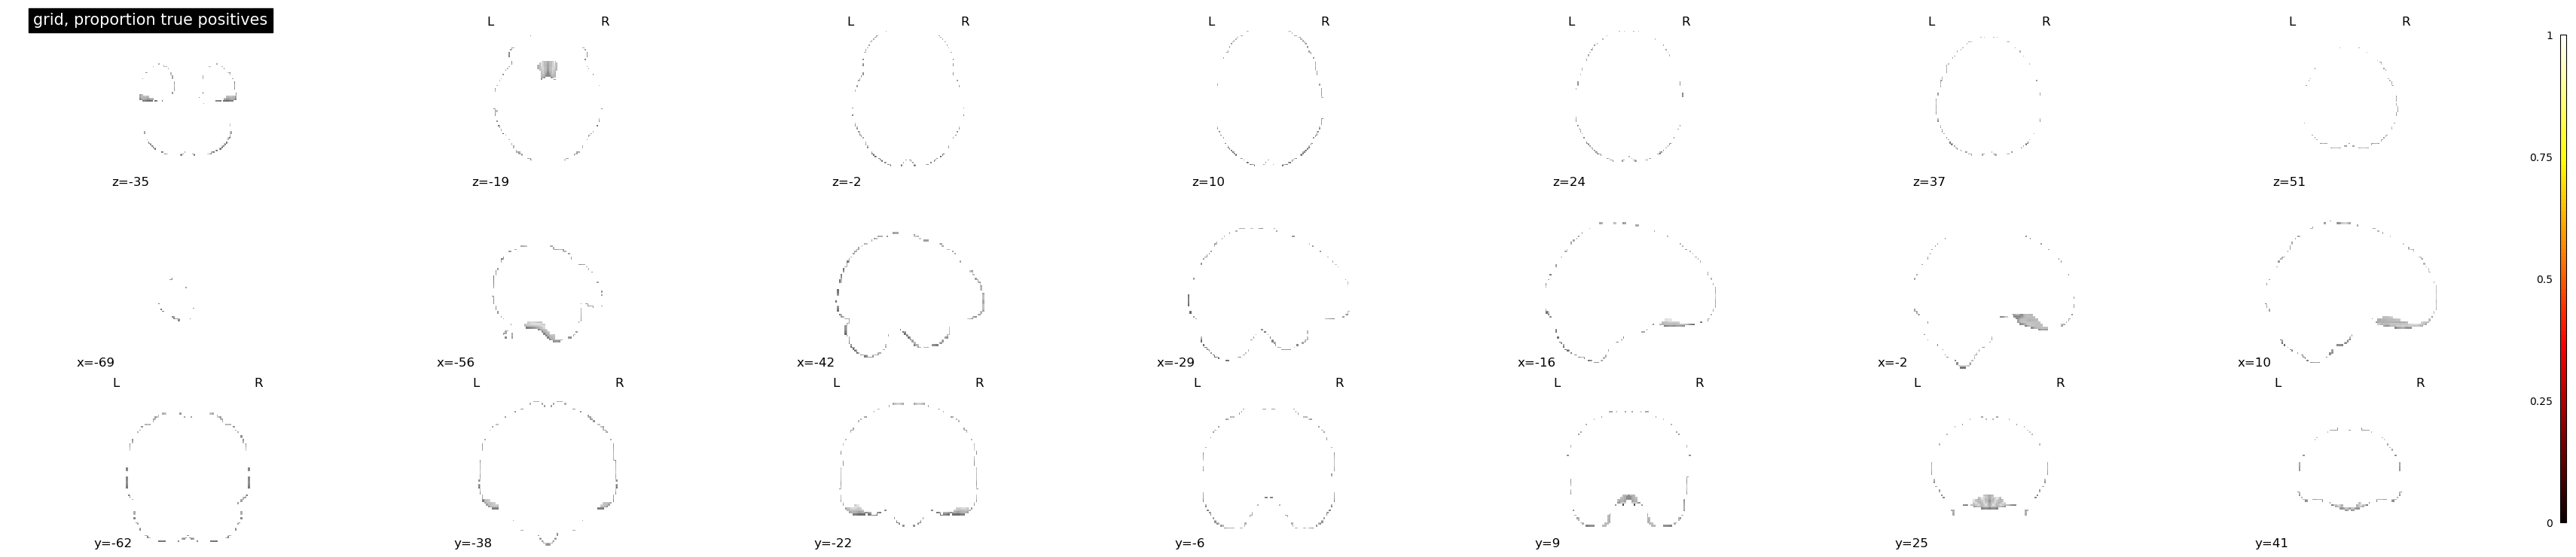

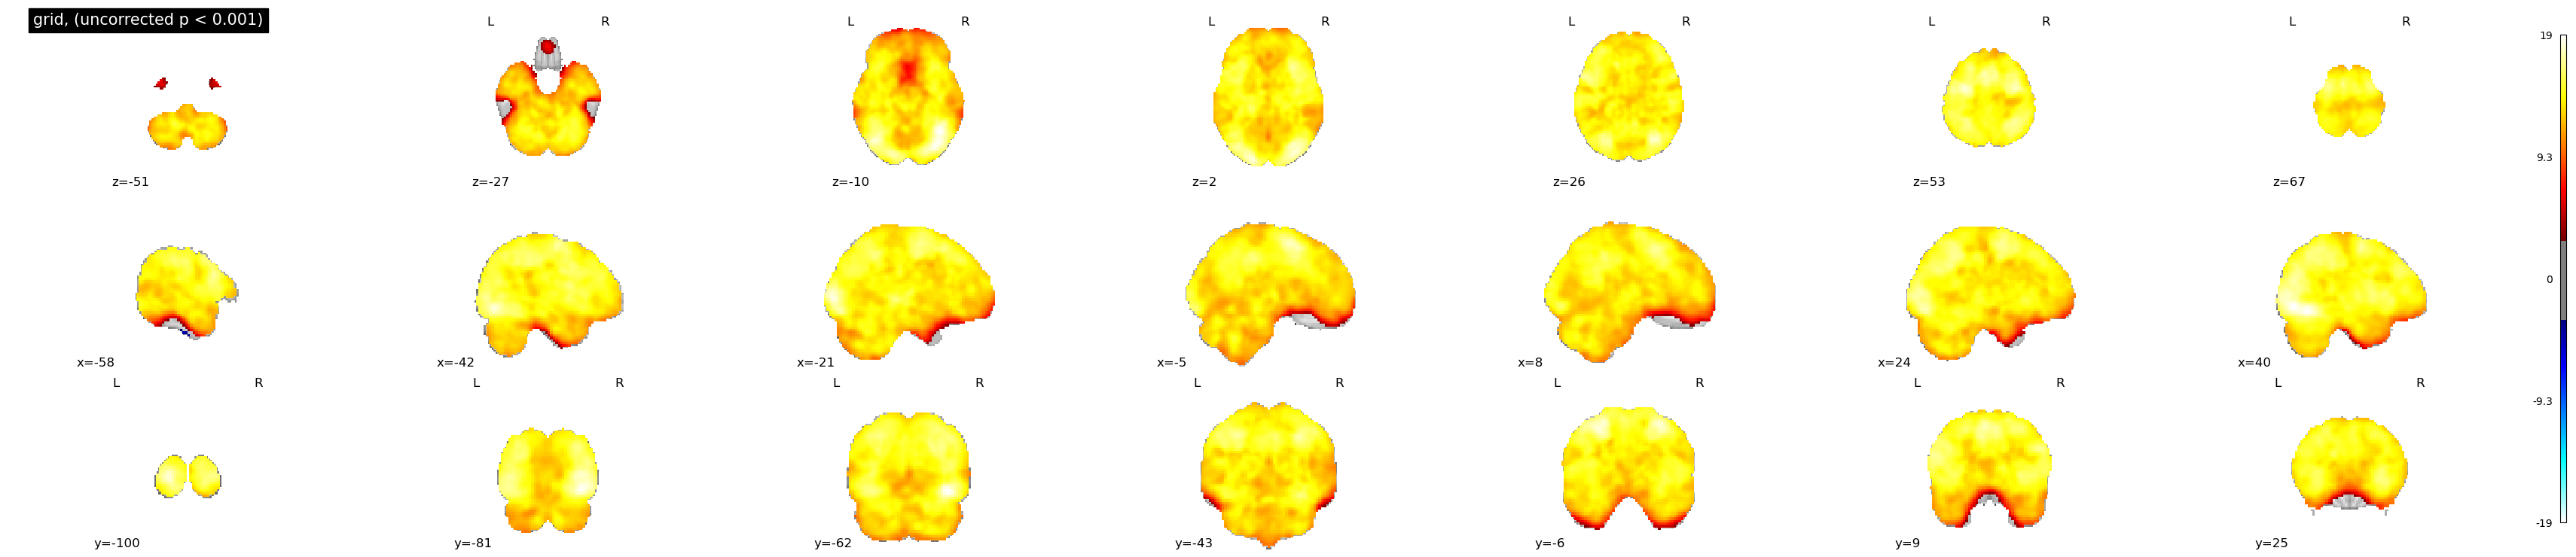

In [13]:
plot_average_nifti(nifti_dir, 'grid')

total number of images: 108


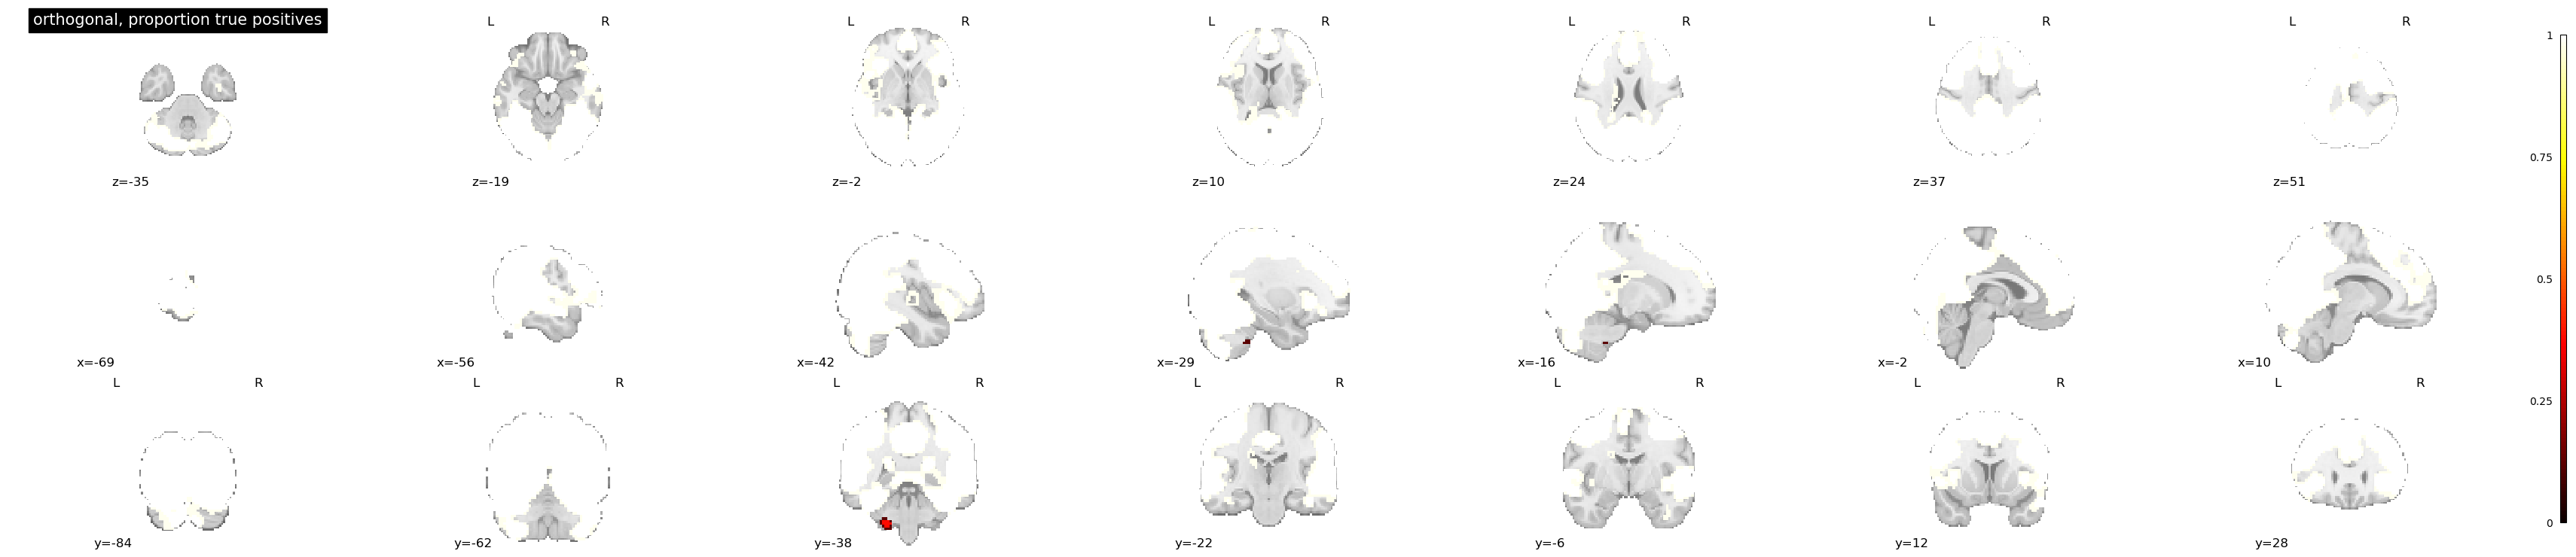

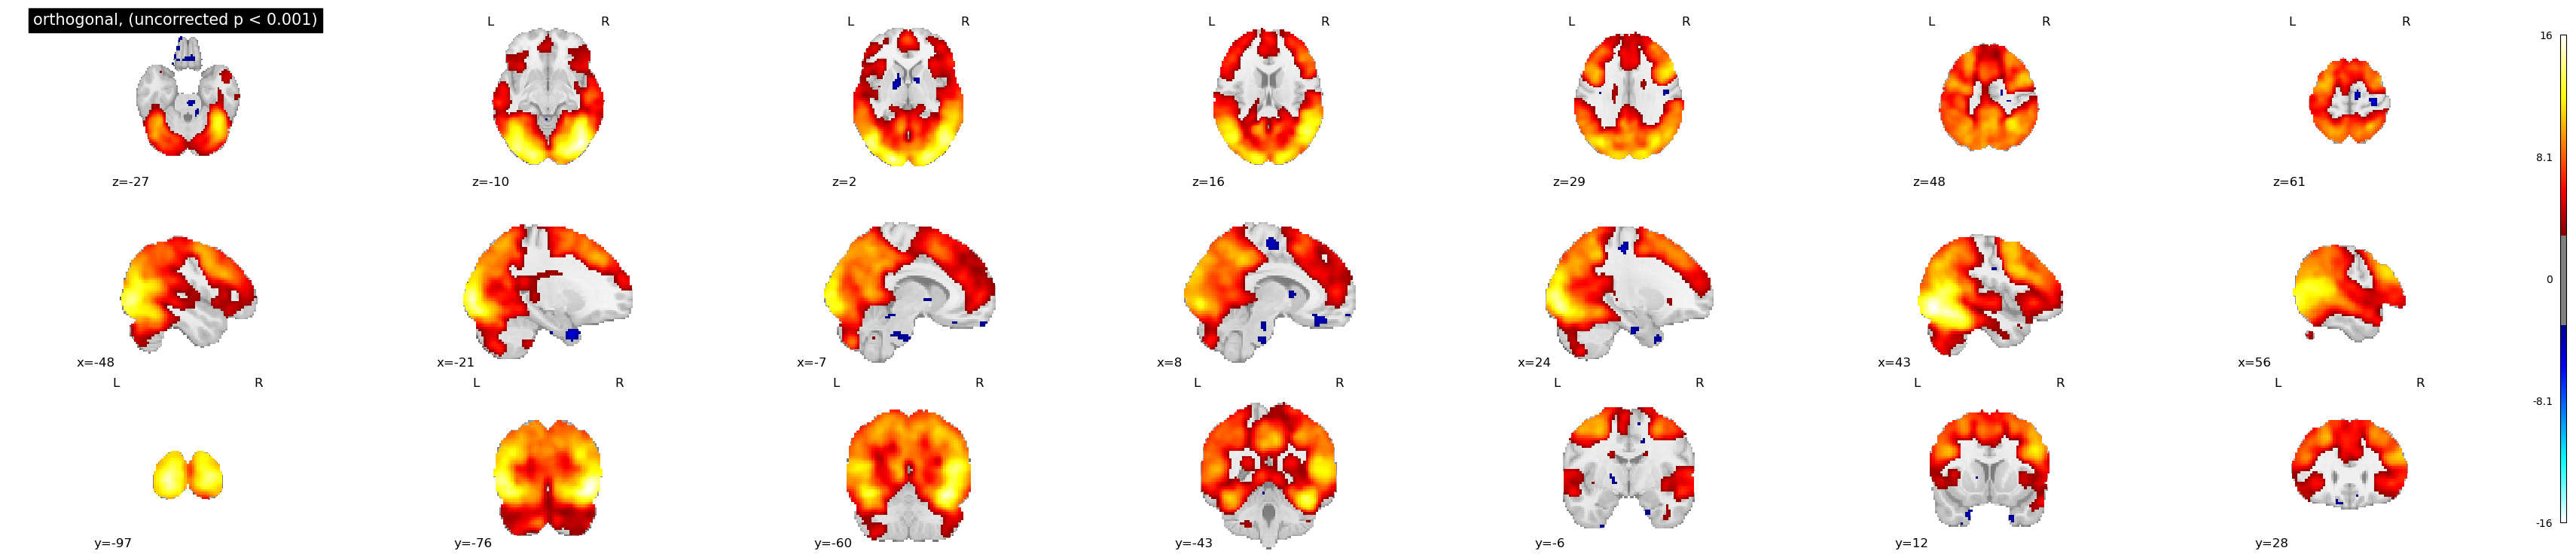

In [14]:
plot_average_nifti(nifti_dir, 'orthogonal')

total number of images: 108


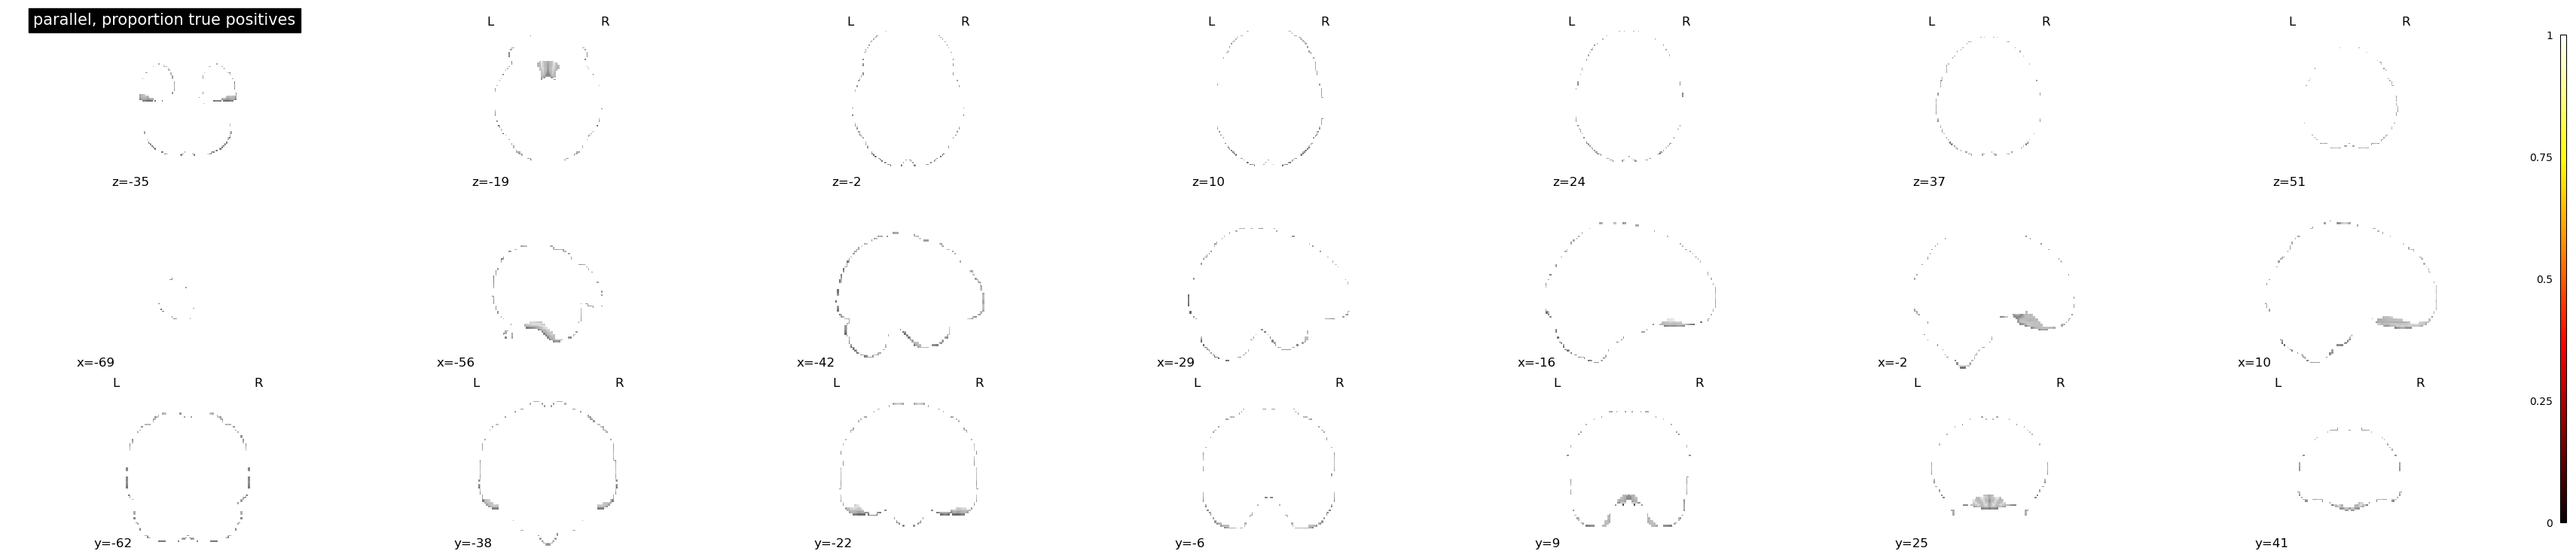

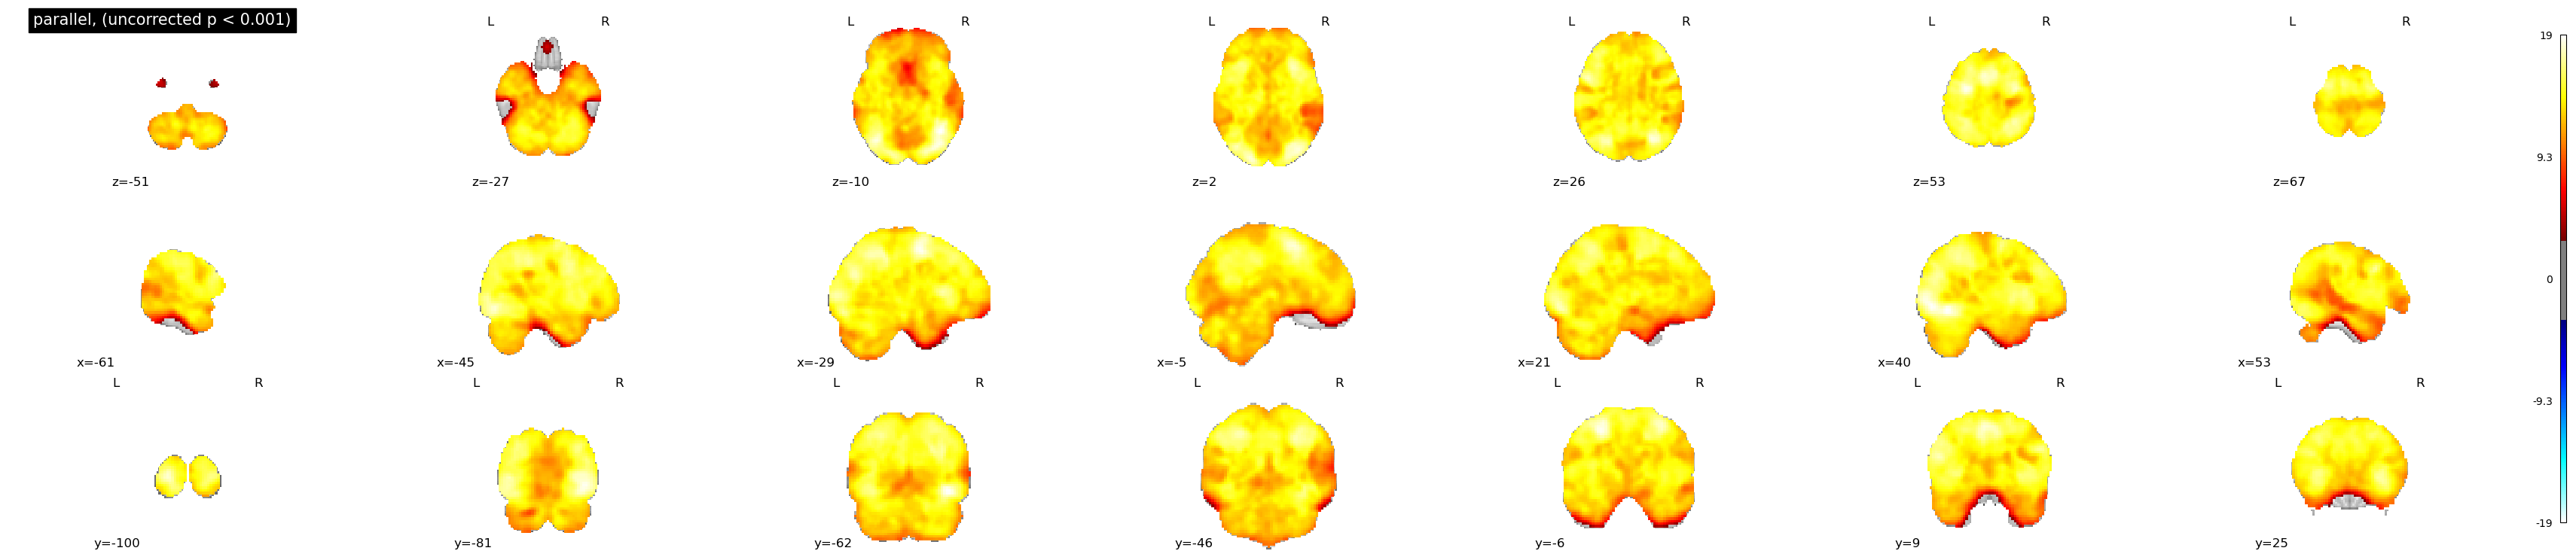

In [15]:
plot_average_nifti(nifti_dir, 'parallel')

total number of images: 108


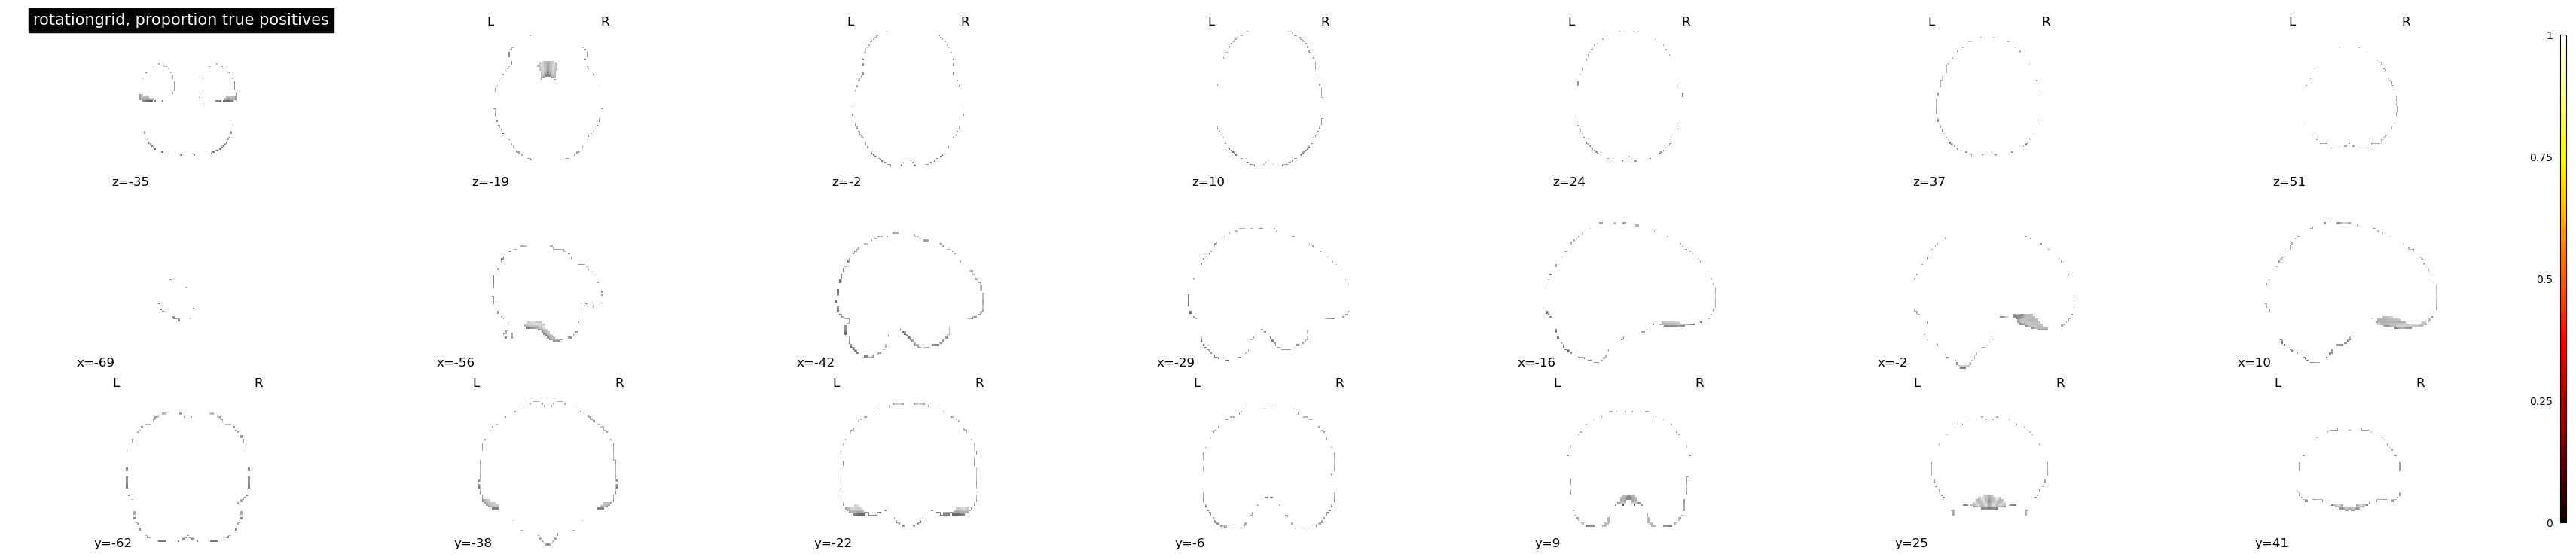

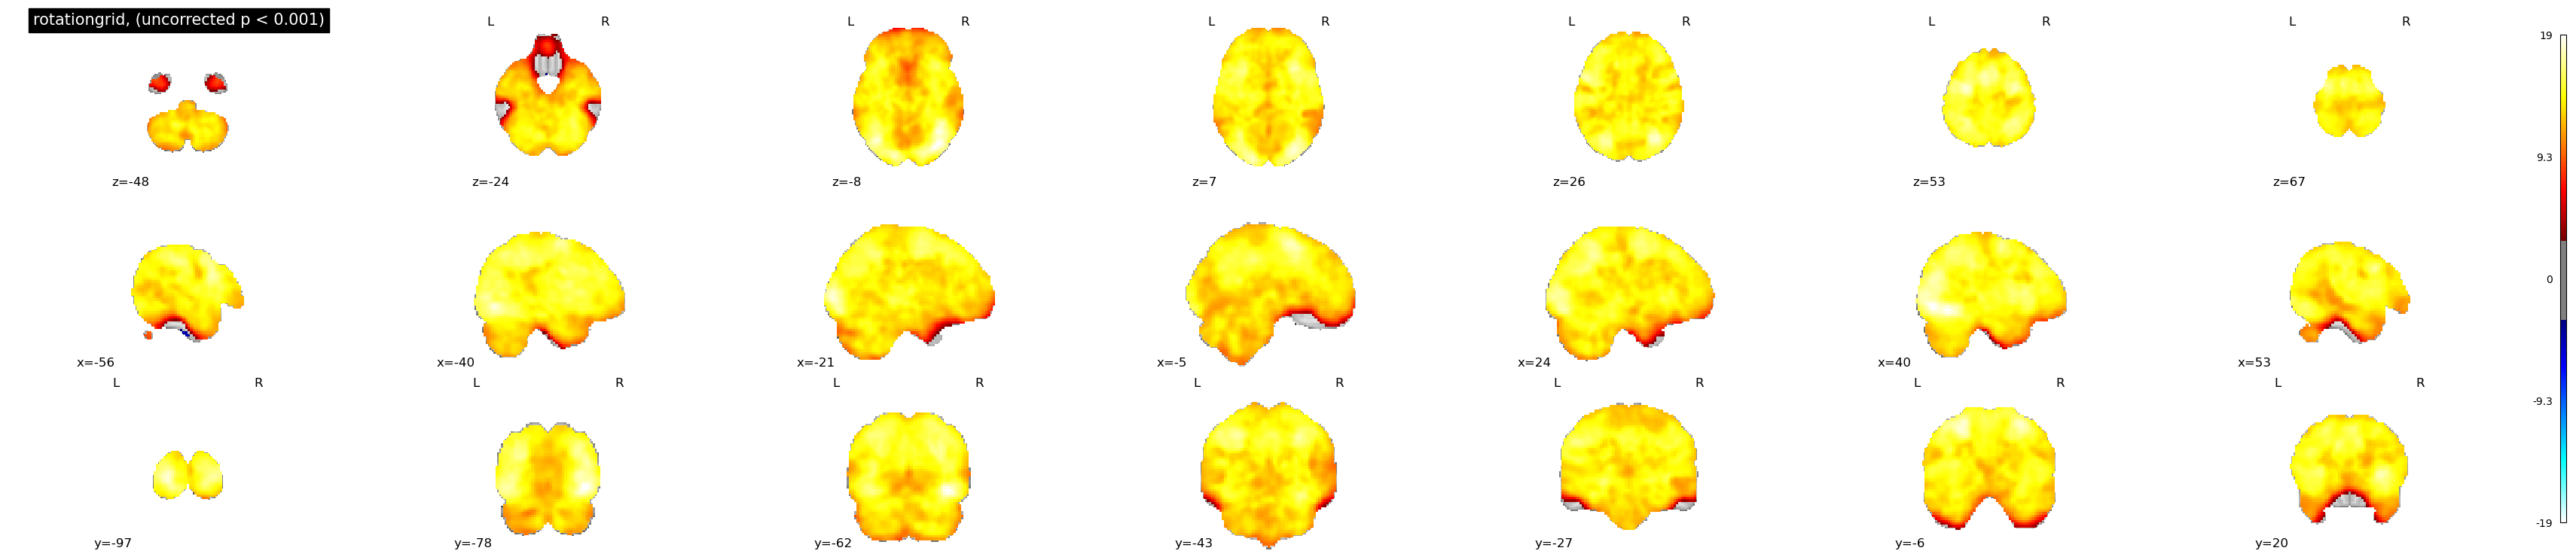

In [16]:
plot_average_nifti(nifti_dir, 'rotationgrid')